In [1]:
import numpy as np
import spectral_embedding as se
import matplotlib as mpl
import matplotlib.pyplot as plt

from itertools import product
from matplotlib import ticker, cm
from scipy.optimize import minimize

We consider a weighted two-community stochastic block model with the communities corresponding to anomalous nodes ($\mathbf{Z}_i = 1$) and normal nodes ($\mathbf{Z}_i = 2$). Edge weights are drawn from a one-inflated beta distribution,
$$
    \mathbf{A}_{ij} \mid \mathbf{Z}_i, \mathbf{Z}_j  \stackrel{\mathrm{ind}}{\sim} 
    (1 - \rho) \delta_1  + \rho \, \textrm{Beta}(\alpha_{\mathbf{Z}_i \mathbf{Z}_j}, 1).
$$

$\pi$ denotes the proability that a node is anomalous, $\rho$ denotes the one-inflation parameter, the chance that a p-value is computed for that edge. In this experiment we assume that the most general case and have both $\alpha_{11}, \alpha_{12} < 1$ although $\alpha_{22} = 1$ for normal nodes. In this case, the block mean and variance matrices after transformations has the form,
$$
    B = \left( \begin{array}{cc}
        b_1 & b_2 \\
        b_2 & b_3
        \end{array} \right), \quad
    C = \left( \begin{array}{cc}
        c_1 & c_2 \\
        c_2 & c_3
        \end{array} \right).
$$
In this case, the size-adjusted Chernoff information cannot be calculated in a closed-form and we have to perform the optimisation numerically using the following functions for the Renyi divergence.

In [2]:
def logit(x):
    return 1/(1 + np.exp(-x))

In [3]:
def Renyi_Divergence(t, pi, b1, b2, b3, c1, c2, c3):   
    if (c1 == 0 and c2 == 0) or (c2 == 0 and c3 == 0):
        return 0.0
    else:
        return 0.5*t*(1-t)*(pi*(b1-b2)**2/((1-t)*c1 + t*c2) + (1-pi)*(b2-b3)**2/((1-t)*c2 + t*c3))

In [4]:
def fThres(x, params):
    t = logit(x)
    pi, b1, b2, b3, c1, c2, c3 = params
    return -Renyi_Divergence(t, pi, b1, b2, b3, c1, c2, c3)

Determine the values of $\pi$ and $\rho$ that we wish to analyse. For each pair of these parameters, construct a grid of values for $\alpha_{11}$ and $\alpha_{12}$. For every combination of parameter, construct the Chernoff information for the p-values directly, the log p-values, and threshold p-values using thresholds $\tau = 0.1, 0.05, 0.01$.

Note that this code can be quite time-consuming depending on the resolution for the $\alpha$ parameter grid. The plots in the paper where generated using 250 points in each dimension.

In [5]:
pis = [0.1, 0.5]
rhos = [0.05, 0.25, 0.50]
n_pi = len(pis)
n_rho = len(rhos)

n_alpha = 100
n_beta = 100
alphas = np.linspace(1/(2*n_alpha), 1-1/(2*n_alpha), n_alpha)
betas = np.linspace(1/(2*n_beta), 1-1/(2*n_beta), n_beta)

In [6]:
%%time
CIs_Raw = np.zeros((n_pi, n_rho, n_alpha, n_beta))

for (j, k, l) in product(range(n_rho), range(n_alpha), range(n_beta)):
    rho = rhos[j]
    alpha = alphas[k]
    beta = betas[l]

    b1 = 1 / (alpha+1); bp1 = rho*b1 
    b2 = 1 / (beta+1); bp2 = rho*b2
    b3 = 1/2; bp3 = rho*b3
    c1 = alpha / ((alpha+2)*(alpha+1)**2); cp1 = rho*c1 + rho*(1-rho)*b1**2
    c2 = beta / ((beta+2)*(beta+1)**2); cp2 = rho*c2 + rho*(1-rho)*b2**2
    c3 = 1/12; cp3 = rho*c3 + rho*(1-rho)*b3**2
    
    for i in range(n_pi):
        pi = pis[i]
        res = minimize(fThres, 0.0, [pi, bp1, bp2, bp3, cp1, cp2, cp3], method='TNC', tol=1e-10)
        CIs_Raw[i,j,k,l] = -res.fun[0]

CPU times: user 2min 29s, sys: 2.95 s, total: 2min 32s
Wall time: 2min 32s


In [7]:
%%time
CIs_Log = np.zeros((n_pi, n_rho, n_alpha, n_beta))

for (j, k, l) in product(range(n_rho), range(n_alpha), range(n_beta)):
    rho = rhos[j]
    alpha = alphas[k]
    beta = betas[l]
    
    b1 = alpha; bp1 = rho*b1
    b2 = beta; bp2 = rho*b2
    b3 = 1; bp3 = rho*b3
    c1 = alpha**2; cp1 = rho*c1 + rho*(1-rho)*b1**2
    c2 = beta**2; cp2 = rho*c2 + rho*(1-rho)*b2**2
    c3 = 1; cp3 = rho*c3 + rho*(1-rho)*b3**2
    
    for i in range(n_pi):
        pi = pis[i]
        res = minimize(fThres, 0.0, [pi, bp1, bp2, bp3, cp1, cp2, cp3], method='TNC', tol=1e-10)
        CIs_Log[i,j,k,l] = -res.fun[0]

CPU times: user 2min 56s, sys: 3.21 s, total: 2min 59s
Wall time: 2min 58s


In [8]:
%%time
CIs_010 = np.zeros((n_pi, n_rho, n_alpha, n_beta))

for (j, k, l) in product(range(n_rho), range(n_alpha), range(n_beta)):
    rho = rhos[j]
    alpha = alphas[k]
    beta = betas[l]
    
    b1 = 0.10**alpha; bp1 = rho*b1
    b2 = 0.10**beta; bp2 = rho*b2
    b3 = 0.10; bp3 = rho*b3
    c1 = 0.10**alpha * (1-0.10**alpha); cp1 = rho*c1 + rho*(1-rho)*b1**2
    c2 = 0.10**beta * (1-0.10**beta); cp2 = rho*c2 + rho*(1-rho)*b2**2
    c3 = 0.10*(1-0.10); cp3 = rho*c3 + rho*(1-rho)*b3**2   
    
    for i in range(n_pi):
        pi = pis[i]
        res = minimize(fThres, 0.0, [pi, bp1, bp2, bp3, cp1, cp2, cp3], method='TNC', tol=1e-10)
        CIs_010[i,j,k,l] = -res.fun[0]

CPU times: user 2min 47s, sys: 3.56 s, total: 2min 50s
Wall time: 2min 48s


In [9]:
%%time
CIs_005 = np.zeros((n_pi, n_rho, n_alpha, n_beta))

for (j, k, l) in product(range(n_rho), range(n_alpha), range(n_beta)):
    rho = rhos[j]
    alpha = alphas[k]
    beta = betas[l]
    
    b1 = 0.05**alpha; bp1 = rho*b1
    b2 = 0.05**beta; bp2 = rho*b2
    b3 = 0.05; bp3 = rho*b3
    c1 = 0.05**alpha * (1-0.05**alpha); cp1 = rho*c1 + rho*(1-rho)*b1**2
    c2 = 0.05**beta * (1-0.05**beta); cp2 = rho*c2 + rho*(1-rho)*b2**2
    c3 = 0.05*(1-0.05); cp3 = rho*c3 + rho*(1-rho)*b3**2   
    
    for i in range(n_pi):
        pi = pis[i]
        res = minimize(fThres, 0.0, [pi, bp1, bp2, bp3, cp1, cp2, cp3], method='TNC', tol=1e-10)
        CIs_005[i,j,k,l] = -res.fun[0]

CPU times: user 2min 50s, sys: 3.53 s, total: 2min 53s
Wall time: 2min 51s


In [10]:
%%time
CIs_001 = np.zeros((n_pi, n_rho, n_alpha, n_beta))

for (j, k, l) in product(range(n_rho), range(n_alpha), range(n_beta)):
    rho = rhos[j]
    alpha = alphas[k]
    beta = betas[l]
    
    b1 = 0.01**alpha; bp1 = rho*b1
    b2 = 0.01**beta; bp2 = rho*b2
    b3 = 0.01; bp3 = rho*b3
    c1 = 0.01**alpha * (1-0.01**alpha); cp1 = rho*c1 + rho*(1-rho)*b1**2
    c2 = 0.01**beta * (1-0.01**beta); cp2 = rho*c2 + rho*(1-rho)*b2**2
    c3 = 0.01*(1-0.01); cp3 = rho*c3 + rho*(1-rho)*b3**2   
    
    for i in range(n_pi):
        pi = pis[i]
        res = minimize(fThres, 0.0, [pi, bp1, bp2, bp3, cp1, cp2, cp3], method='TNC', tol=1e-10)
        CIs_001[i,j,k,l] = -res.fun[0]

CPU times: user 2min 56s, sys: 4.28 s, total: 3min
Wall time: 2min 57s


For the five different representations for the p-values, determine which gives the best Chernoff information for that particular tuple of parameter values.

In [11]:
CIs_Regs = np.zeros((n_pi, n_rho, n_alpha, n_beta))

for (i, j, k, l) in product(range(n_pi), range(n_rho), range(n_alpha), range(n_beta)):
    CIs_Regs[i,j,k,l] = np.argmax([CIs_Raw[i,j,k,l], CIs_Log[i,j,k,l], CIs_001[i,j,k,l], 
                                   CIs_005[i,j,k,l], CIs_010[i,j,k,l]])

Prepare the colour palette for the plots.

In [12]:
contour_cols = ['tab:red', 'white', 
                plt.get_cmap('Blues')(0.3), plt.get_cmap('Blues')(0.5), plt.get_cmap('Blues')(0.7)]

In [13]:
fig = plt.figure()
handles = [plt.scatter([],[], color=contour_cols[1], marker='o', s=16, edgecolors='black', label=r'Log p-values'),
           plt.scatter([],[], color=contour_cols[2], marker='o', s=16, label=r'Threshold 0.01'),
           plt.scatter([],[], color=contour_cols[3], marker='o', s=16, label=r'Threshold 0.05'),
           plt.scatter([],[], color=contour_cols[4], marker='o', s=16, label=r'Threshold 0.10')]
plt.close()

Plot the phase diagrams showing which p-value representation results in the greatest size-adjusted Chernoff information.

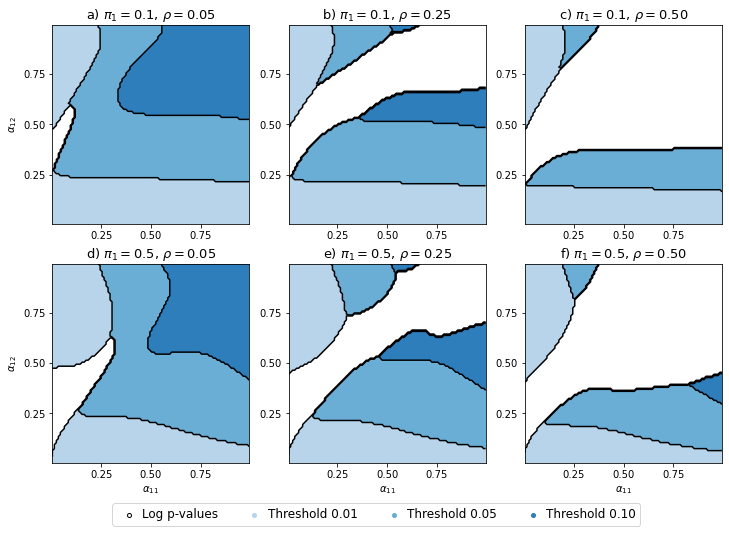

In [14]:
X, Y = np.meshgrid(alphas, betas)

fig, axs = plt.subplots(n_pi, n_rho, figsize=(12.0,8.0))
levels = [-0.5,0.5,1.5,2.5,3.5,4.5]

for (i, j) in product(range(n_pi), range(n_rho)):
    csf = axs[i,j].contourf(X, Y, CIs_Regs[i,j].T, colors=contour_cols, levels=levels)
    cs = axs[i,j].contour(X, Y, CIs_Regs[i,j].T, colors='k',
                          linestyles=['-','-','-','-'], levels=[1.0,2.0,3.0,4.0])
    axs[i,j].set_xticks(np.arange(0.25,1.0,0.25))
    axs[i,j].set_yticks(np.arange(0.25,1.0,0.25))

for i in range(n_pi):
    axs[i,0].set_ylabel(r'$\alpha_{12}$')

for j in range(n_rho):
    axs[n_pi-1,j].set_xlabel(r'$\alpha_{11}$')  

axs[0,0].set_title(r'a) $\pi_1 = 0.1$, $\rho = 0.05$', fontsize=13)
axs[0,1].set_title(r'b) $\pi_1 = 0.1$, $\rho = 0.25$', fontsize=13)
axs[0,2].set_title(r'c) $\pi_1 = 0.1$, $\rho = 0.50$', fontsize=13)
axs[1,0].set_title(r'd) $\pi_1 = 0.5$, $\rho = 0.05$', fontsize=13)
axs[1,1].set_title(r'e) $\pi_1 = 0.5$, $\rho = 0.25$', fontsize=13)
axs[1,2].set_title(r'f) $\pi_1 = 0.5$, $\rho = 0.50$', fontsize=13)

fig.legend(handles=handles, bbox_to_anchor=(0.5,0), loc='lower center', ncol=4, fancybox=True,
           fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom = 0.12);